## 1. IMPORT THƯ VIỆN VÀ THIẾT LẬP MÔI TRƯỜNG

In [1]:
try:
    import torch
    import matplotlib.pyplot as plt
    import numpy as np
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from scipy.stats import shapiro
    from imblearn.over_sampling import SMOTE, RandomOverSampler
    import seaborn as sns
    import pandas as pd
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
    from sklearn.utils.class_weight import compute_class_weight
    from ucimlrepo import fetch_ucirepo
    print("All libraries loaded successfully!")
except ImportError as e:
    print(f"Error: {e.name} library is missing. Installing...")
    missing_lib = e.name
    # Tự động cài đặt thư viện thiếu
    if missing_lib == 'torch':
        !pip install torch
    elif missing_lib == 'matplotlib':
        !pip install matplotlib
    elif missing_lib == 'numpy':
        !pip install numpy
    elif missing_lib == 'scikit-learn':
        !pip install scikit-learn
    elif missing_lib == 'imbalanced-learn':
        !pip install imbalanced-learn
    elif missing_lib == 'seaborn':
        !pip install seaborn
    elif missing_lib == 'pandas':
        !pip install pandas
    elif missing_lib == 'scipy':
        !pip install scipy
    elif missing_lib == 'ucimlrepo':
        !pip install ucimlrepo
    # Sau khi cài đặt xong, thử lại việc import
    print(f"Successfully installed {missing_lib}. Please re-run the code.")

# Thiết lập GPU nếu có
torch.backends.cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

All libraries loaded successfully!
Using device: cuda:0


## 2. THU THẬP DỮ LIỆU

In [2]:
wine_quality = fetch_ucirepo(id=186)
df = wine_quality.data.original

# Lọc rượu trắng
mask = df["color"] == "white"
df= df[mask]
df= df.drop('color',axis=1)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4898 entries, 1599 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         4898 non-null   float64
 1   volatile_acidity      4898 non-null   float64
 2   citric_acid           4898 non-null   float64
 3   residual_sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free_sulfur_dioxide   4898 non-null   float64
 6   total_sulfur_dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 497.5 KB


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
1599,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1600,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
1601,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
1602,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
1603,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## 3. TIỀN XỬ LÝ DỮ LIỆU

In [3]:
# Kiểm tra giá trị null và trùng lặp
print("Null values:", df.isnull().sum().sum())
print("Duplicate rows:", df.duplicated().sum())

# Loại bỏ hàng trùng lặp và cột color
df = df.drop_duplicates(keep="first")


Null values: 0
Duplicate rows: 937


In [4]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000
mean,6.839346,0.280538,0.334332,5.914819,0.045905,34.889169,137.193512,0.993790,3.195458,0.490351,10.589358,5.854835
std,0.866860,0.103437,0.122446,4.861646,0.023103,17.210021,43.129065,0.002905,0.151546,0.113523,1.217076,0.890683
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.600000,0.035000,23.000000,106.000000,0.991620,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,4.700000,0.042000,33.000000,133.000000,0.993500,3.180000,0.480000,10.400000,6.000000
75%,7.300000,0.330000,0.390000,8.900000,0.050000,45.000000,166.000000,0.995710,3.290000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [5]:
df['quality'].value_counts().sort_values(ascending=False).to_frame()

,quality
6,1788
5,1175
7,689
4,153
8,131
3,20
9,5


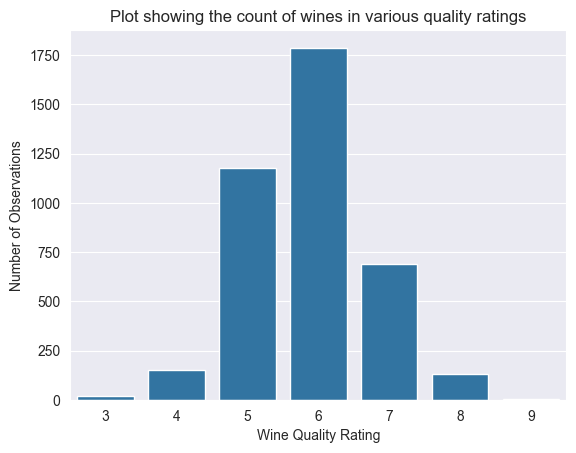

In [6]:
sns.countplot(x='quality',data=df)
plt.title('Plot showing the count of wines in various quality ratings')
plt.xlabel('Wine Quality Rating')
plt.ylabel('Number of Observations')
plt.show()

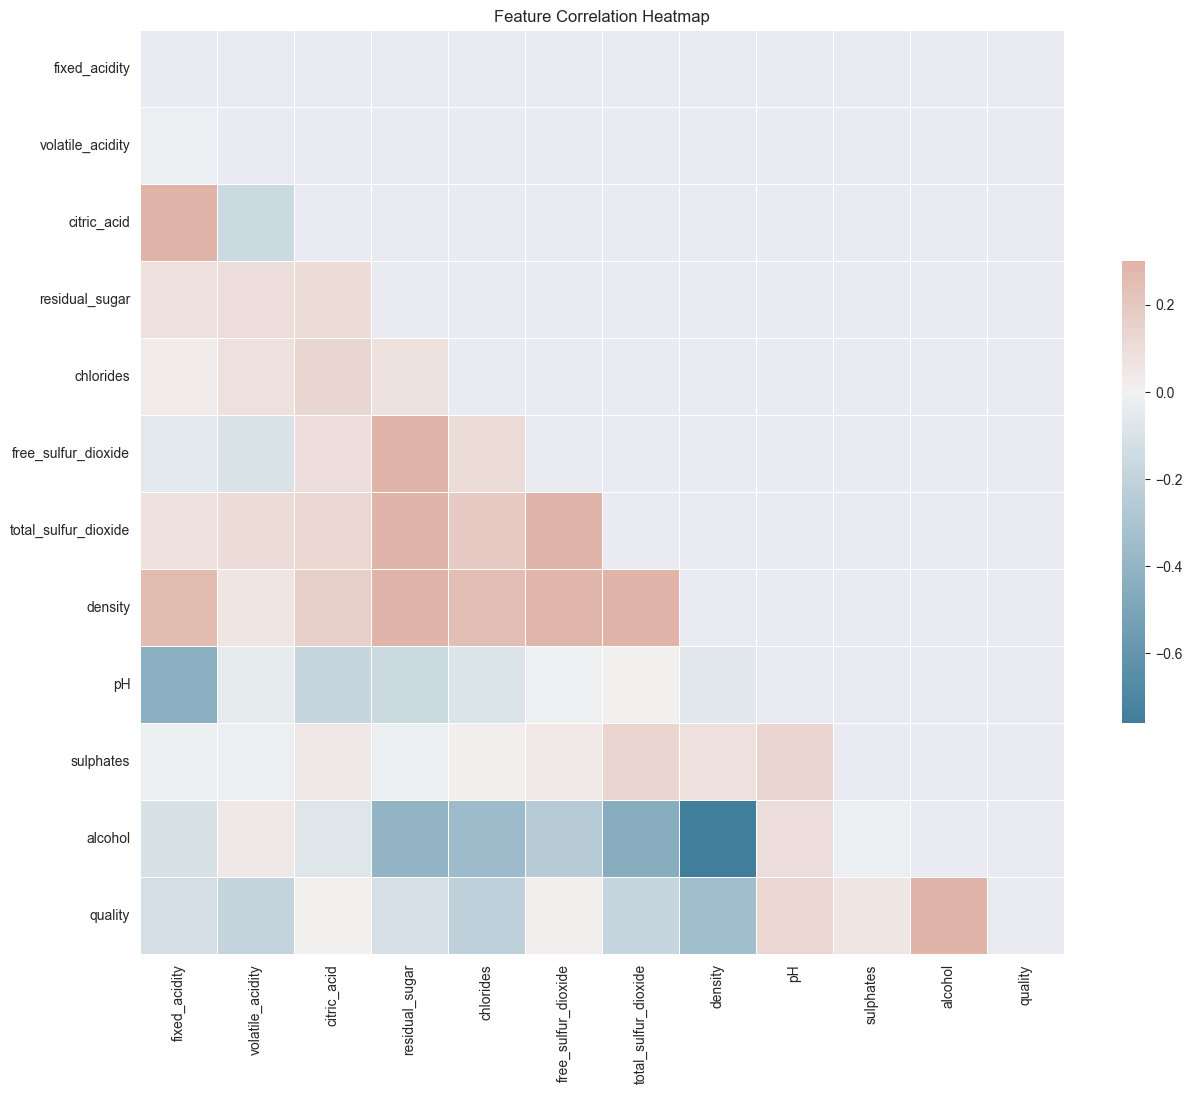

In [7]:
#Plot of correlation
'''Plot of correlation heatmap'''
#calculate the correlation
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

#define the cmap to be used
cmap = sns.diverging_palette(230, 20, as_cmap=True)

#plot the heatmap
plt.figure(figsize=(15,12))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Feature Correlation Heatmap')
plt.show()

In [8]:
df.corr()['quality'].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.462869
pH                      0.123829
sulphates               0.053200
free_sulfur_dioxide     0.010507
citric_acid             0.007065
residual_sugar         -0.117339
fixed_acidity          -0.124636
total_sulfur_dioxide   -0.183356
volatile_acidity       -0.190678
chlorides              -0.217739
density                -0.337805
Name: quality, dtype: float64

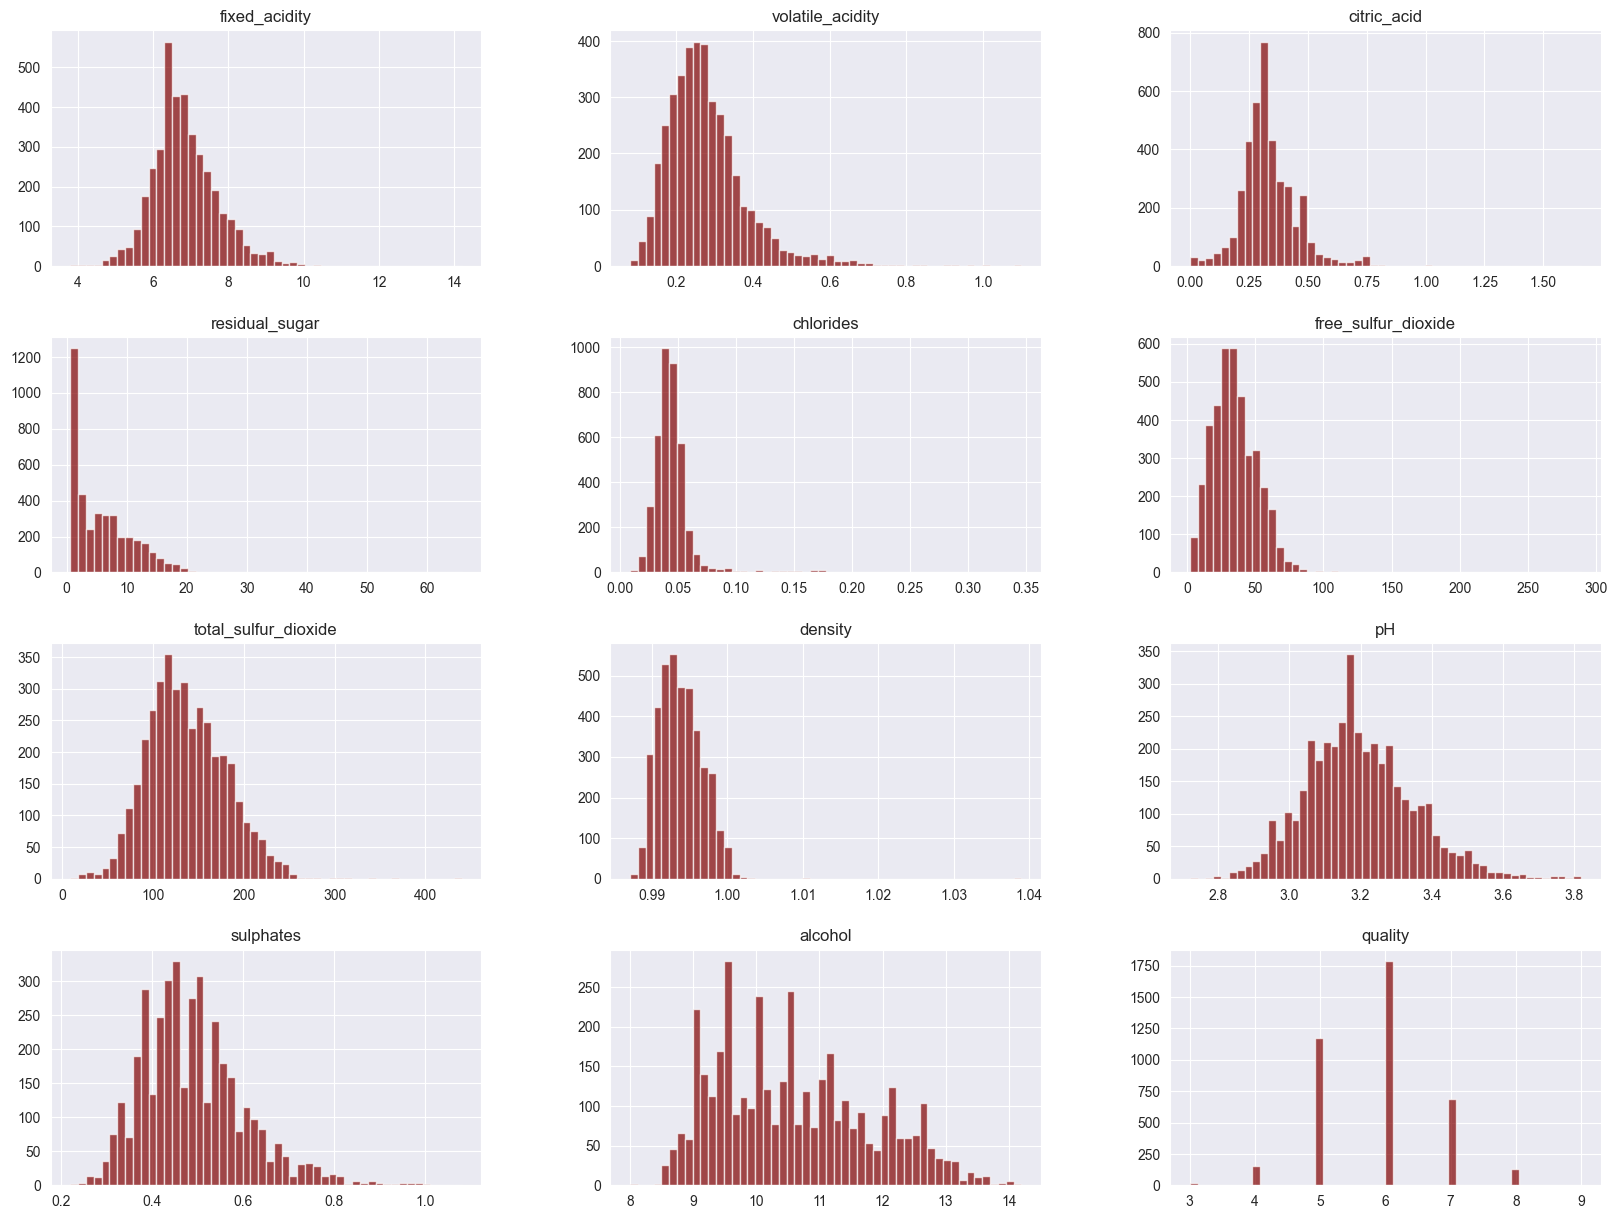

In [9]:
df.hist(bins=50, figsize=(20,15),color='maroon',alpha=0.7)
plt.show()

In [10]:
df.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [11]:
features = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
for feature in features:
    stat, p = shapiro(df[feature])
    print('Feature {}'.format(feature))
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably feature "{}" is Normally Distributed'.format(feature))
        print('\n')
    else:
        print('Probably feature "{}" is not Normally Distributed'.format(feature))
        print('\n')

Feature fixed_acidity
stat=0.974, p=0.000
Probably feature "fixed_acidity" is not Normally Distributed


Feature volatile_acidity
stat=0.898, p=0.000
Probably feature "volatile_acidity" is not Normally Distributed


Feature citric_acid
stat=0.921, p=0.000
Probably feature "citric_acid" is not Normally Distributed


Feature residual_sugar
stat=0.867, p=0.000
Probably feature "residual_sugar" is not Normally Distributed


Feature chlorides
stat=0.578, p=0.000
Probably feature "chlorides" is not Normally Distributed


Feature free_sulfur_dioxide
stat=0.933, p=0.000
Probably feature "free_sulfur_dioxide" is not Normally Distributed


Feature total_sulfur_dioxide
stat=0.986, p=0.000
Probably feature "total_sulfur_dioxide" is not Normally Distributed


Feature density
stat=0.947, p=0.000
Probably feature "density" is not Normally Distributed


Feature pH
stat=0.988, p=0.000
Probably feature "pH" is not Normally Distributed


Feature sulphates
stat=0.956, p=0.000
Probably feature "sulphates" 

In [12]:
def new_quality_rating(rating):
    '''This function will change the target quality rating to 0, 1 or 2.
       The number of target labels will be reduced to 3 instead of 6'''
    if (rating == 3 or rating == 4):
        return 0
    elif (rating == 5 or rating == 6):
        return 1
    else:
        return 2

In [13]:
df['new_quality'] = df['quality'].apply(new_quality_rating)

In [14]:
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,new_quality
1599,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,1
1600,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1
1601,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1
1602,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1
1605,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6,1


In [15]:
new_df = df.copy()
new_df.drop('quality',axis=1,inplace =True)
new_df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,new_quality
1599,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1600,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
1601,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
1602,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
1605,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,1


In [16]:
train,test = train_test_split(new_df,test_size=0.3,random_state=225, shuffle=True)

In [17]:
X_train = train.drop('new_quality',axis=1)
y_train = train['new_quality']

#separate for the test set
X_test = test.drop('new_quality',axis=1)
y_test = test['new_quality']

In [18]:
scaler = StandardScaler()

# fit and transform the train set
X_train = scaler.fit_transform(X_train)
# transform the test set
X_test = scaler.transform(X_test)


In [19]:
train['new_quality'].value_counts()/len(train)

1    0.743867
2    0.212843
0    0.043290
Name: new_quality, dtype: float64

In [20]:
test['new_quality'].value_counts()/len(test)


1    0.757780
2    0.197645
0    0.044575
Name: new_quality, dtype: float64

In [21]:

# Áp dụng SMOTE cho tập huấn luyện
print("Phân phối lớp trước oversampling:", np.bincount(y_train))

# Phương pháp 1: SMOTE (Synthetic Minority Over-sampling Technique)
# SMOTE tạo ra các mẫu mới bằng cách nội suy giữa các mẫu hiện có
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


print("Phân phối lớp sau oversampling:", np.bincount(y_train))

scaler = StandardScaler()

# fit and transform the train set
X_train = scaler.fit_transform(X_train)
# transform the test set
X_test = scaler.transform(X_test)



Phân phối lớp trước oversampling: [ 120 2062  590]
Phân phối lớp sau oversampling: [2062 2062 2062]


C:\Users\My Laptop\miniconda3\envs\conda_envi\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [22]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Thay đổi kiểu dữ liệu
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)  # Thay đổi kiểu dữ liệu

# Tạo DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:

class WineQualityClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(WineQualityClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)

        self.fc2 = nn.Linear(hidden_size, hidden_size*2)
        self.bn2 = nn.BatchNorm1d(hidden_size*2)

        self.fc3 = nn.Linear(hidden_size*2, hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)

        self.fc4 = nn.Linear(hidden_size, num_classes)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = (torch.relu(self.bn1(self.fc1(x))))
        x = (torch.relu(self.bn2(self.fc2(x))))
        x = (torch.relu(self.bn3(self.fc3(x))))
        x = self.fc4(x)
        return x

input_size = X_train.shape[1]
hidden_size = 128
num_classes = 3

model = WineQualityClassifier(input_size, hidden_size, num_classes)
model = model.to(device)
print(model)

WineQualityClassifier(
  (fc1): Linear(in_features=11, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=3, bias=True)
)


In [ ]:

# Định nghĩa hàm huấn luyện và đánh giá
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=100):
    # Theo dõi loss và accuracy
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(num_epochs):
        # --- TRAINING ---
        model.train()  # Chuyển mô hình sang chế độ huấn luyện
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()  # Đảm bảo kiểu dữ liệu là long

            optimizer.zero_grad()  # Làm sạch gradient cũ

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass (tính toán gradient)
            loss.backward()

            # Cập nhật trọng số
            optimizer.step()

            # Tính accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        # Tính average loss và accuracy cho epoch này
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # --- TESTING ---
        model.eval()  # Chuyển mô hình sang chế độ kiểm tra
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Tắt gradient calculation trong quá trình kiểm tra
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).long()  # Đảm bảo kiểu dữ liệu là long

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Tính accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                running_loss += loss.item()

        # Tính average loss và accuracy cho epoch này
        epoch_test_loss = running_loss / len(test_loader)
        epoch_test_acc = 100 * correct / total
        test_losses.append(epoch_test_loss)
        test_accs.append(epoch_test_acc)

        # In thông tin mỗi 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, '
                  f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%')

    print('Training complete!')
    return train_losses, test_losses, train_accs, test_accs

# Định nghĩa hàm đánh giá mô hình
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels

# Khởi tạo loss function với class weights để xử lý imbalance
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()

# Khởi tạo optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001, weight_decay=1e-4)

# Huấn luyện mô hình
train_losses, test_losses, train_accs, test_accs = train_and_evaluate(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=300
)

# Vẽ biểu đồ theo dõi quá trình hội tụ (converge)
plt.figure(figsize=(12, 5))

# Biểu đồ loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.title('Training and Test Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Đánh giá mô hình với các metric yêu cầu
predictions, true_labels = evaluate_model(model, test_loader)

# Accuracy
print(f"\nAccuracy: {accuracy_score(true_labels, predictions):.4f}")

# Classification report (precision, recall, f1-score, support)
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=['Class 0 (Low)', 'Class 1 (Medium)', 'Class 2 (High)']))

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0\n(Low)', 'Class 1\n(Medium)', 'Class 2\n(High)'],
            yticklabels=['Class 0\n(Low)', 'Class 1\n(Medium)', 'Class 2\n(High)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Chi tiết metrics cho từng class
precision, recall, f1, support = precision_recall_fscore_support(true_labels, predictions)

# Tạo DataFrame để hiển thị các metric
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1,
    'Support': support
}, index=['Class 0 (Low)', 'Class 1 (Medium)', 'Class 2 (High)'])

print("\nPerformance metrics for each class:")
print(metrics_df)

# Vẽ biểu đồ so sánh metrics
metrics_df[['Precision', 'Recall', 'F1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Performance Metrics by Class')
plt.ylabel('Score')
plt.xlabel('Class')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
